# Predicting_Bike_Rentals

In this project, we predicted the total number of bikes people rented in a given hour. We predicted the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, we created a few different machine learning models and evaluate their performance.

The file which we worked upon, contains `17380` rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here's what that first five rows look like:

<img src="first_five_rows.png">

Below are the descriptions for the relevant columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred
- `yr` - The year the rentals occurred
- `mnth` - The month the rentals occurred
- `hr` - The hour the rentals occurred
- `holiday` - Whether or not the day was a holiday
- `weekday` - The day of the week (as a number, 0 to 6)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather (as a categorical variable)
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted temperature
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't - previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline 

# reading file into dataframe
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [2]:
# examining rows of dataframe
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

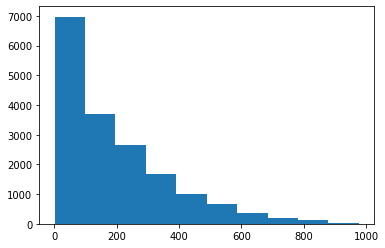

In [4]:
# looking at the distribution of totals rentals using histogram
plt.hist(bike_rentals['cnt'])

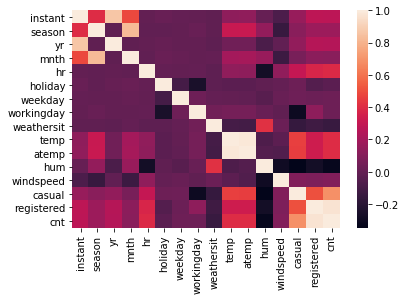

In [5]:
# determining correlation between variables using heatmap
sns.heatmap(bike_rentals.corr())

In [6]:
# exploring correlation of each column in dataframe with `cnt`
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [7]:
# defining function to assign labels to `hr` column
def assign_label(hour):
    if hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3
    elif hour >= 0 and hour < 6:
        return 4

# creating new column and assigning labels to it
bike_rentals['time_label'] = bike_rentals.hr.apply(assign_label)

# examining frequencies of values in time_label column
bike_rentals.time_label.value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

In [8]:
# We will use mean squared error metric to evaluate (our error) the performance
# of ML algorithms. MSE works on continuous numeric data, which fits our data
# quite well.

# splitting 80% of rows in dataframe to be in train set
train = bike_rentals.sample(frac=0.8)

# selecting the rows that are in bike_rentals but not in train
# to be in the test set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

We utilized the linear regression model given that many of the columns are highly correlated with `cnt`. Also linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward.

In [9]:
# ignoring the columns `casusal` and `registered` as `cnt`, which we'll
# predict is derived from both.

predictors = list(train.columns)
predictors.remove('cnt')
predictors.remove('casual')
predictors.remove('dteday')
predictors.remove('registered')

# instantiating the model
lin_reg = LinearRegression()

# fitting model to the train set
lin_reg.fit(train[predictors], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# predicting using linear regression class on test set
predictions = lin_reg.predict(test[predictors])

# calculatting error between actual values and predictions
mse = mean_squared_error(test['cnt'], predictions)
mse

16524.362513936103

The above error is very high probably due to the fact that the data has a few extremely high rental counts. However, larger errors are penalized more with Mean Squared Error, which leads to a higher total error.

Now, applying the decision tree algorithm to compare its error with the error from linear regression to enable us to pick the right algorithm for the dataset.

In [11]:
# instantiating the decision tree regressor class
dt_reg = DecisionTreeRegressor(min_samples_leaf=5)

# fitting the class to train data
dt_reg.fit(train[predictors], train['cnt'])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [12]:
# making predictions on test set
predictions = dt_reg.predict(test[predictors])

# calculating error between predictions and actual label
mse = mean_squared_error(test['cnt'], predictions)
mse

2657.6512057712043

Decision tree regressor takes into account of non-linear variables, whereas Linear regressor do not and therefore, the decision tree regressor appears to have much higher accuracy than linear regression.

In [13]:
# instantiating the random forest regressor class
rf_reg = RandomForestRegressor(min_samples_leaf=5)

# fitting the class to train data
rf_reg.fit(train[predictors], train['cnt'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [14]:
# making predictions on test set
predictions = rf_reg.predict(test[predictors])

# calculating error between predictions and actual label
mse = mean_squared_error(test['cnt'], predictions)
mse

1689.9191975338895

Above calculated error confirms that by removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.